# ECE 232E - Project 3: Reinforcement Learning and Inverse Reinforcement Learning

1.   In **Part 1** of this notebook we implement **reinforcement learning** to train an agent to navigate a maze with an optimum (shortest) path.
2.   In **Part 2** we will use our results from part 1 to implement inverse reinforcement learning (train an apprentice ajent using an expert's optimal policy). Then we will compare our results.

# Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import numpy.random as rn

from cvxopt import solvers, matrix
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set() #for advanced plot styling
%matplotlib inline

image_path = 'drive/MyDrive/ECE 232/Project 3/Images/'

# Gridworld object definition
*We will use the project provided helper code as a starting point*

In [ ]:
# Define the gridworld MDP class
class Gridworld(object):

    # The GridWorld object is initialized with the following:
    #
    #  grid_size: (int) Represents the width and height of the grid
    #.      wind: (float) Represents the probability of moving in a random
    #             direction due to being blown by the wind.
    #.  discount: (float between 0 and 1) Represents gamma - the dicounted
    #             amount of past actions
    def __init__(self, grid_size, wind, discount):

        # Possible moves
        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)

        # Initialize properties of the grid space
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount

        # Preconstruct the transition probability array.
        self.tr_probs = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])

        # Set up reward matrix options
        self.reward1 = np.array([[  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                                 [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                                 [  0,  0,  0,  0,  0,-10,-10,  0,  0,  0],
                                 [  0,  0,  0,  0,  0,-10,-10,  0,  0,  0],
                                 [  0,-10,-10,  0,  0,  0,  0,  0,  0,  0],
                                 [  0,-10,-10,  0,  0,  0,  0,  0,  0,  0],
                                 [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                                 [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                                 [  0,  0,-10,-10,  0,  0,  0,  0,  0,  0],
                                 [  0,  0,-10,-10,  0,  0,  0,  0,  0,  1]])

        self.reward2 = np.array([[   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                 [   0,   0,   0,   0,-100,-100,-100,   0,   0,   0],
                                 [   0,   0,   0,   0,-100,   0,-100,   0,   0,   0],
                                 [   0,   0,   0,   0,-100,   0,-100,-100,-100,   0],
                                 [   0,   0,   0,   0,-100,   0,   0,   0,-100,   0],
                                 [   0,   0,   0,   0,-100,   0,   0,   0,-100,   0],
                                 [   0,   0,   0,   0,-100,   0,   0,   0,-100,   0],
                                 [   0,   0,   0,   0,   0,   0,-100,-100,-100,   0],
                                 [   0,   0,   0,   0,   0,   0,-100,   0,   0,   0],
                                 [   0,   0,   0,   0,   0,   0,   0,   0,   0,  10]])


        # Initialize the reward_function attribute to one of the functions above
        self.set_reward_function()

        # Create a reshaped version of the transition probability matrix
        self.reshape_tr_prob()

    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    # Convert a state int into the corresponding coordinate.
    #   Params:
    #        i: (int) representing the index of an individual state in the flattened
    #           grid array
    #  Returns: (int tuple) representing the (r, c) coordinate position in the grid
    def int_to_point(self, i):
        return (i % self.grid_size, i // self.grid_size)

    # Convert a grid (x, y) coordinate position into a state integer - position
    # in a flattened grid.
    #   Params:
    #        p: (int tuple) representing the individual state's (r, c) coordinate
    #           position in the grid
    #  Returns: (int) representing the index of the state in the flattened
    #           grid array
    def point_to_int(self, p):
        return int(p[0] + p[1]*self.grid_size)

    # Determine if two points neighbour each other. A point is also considered a
    # neighbor of itself
    #   Params:
    #        i: (int tuple) representing the (r, c) coordinate of the first state
    #        k: (int tuple) representing the (r, c) coordinate of the second state
    #  Returns: (boolean) indicating if the states are neighbors.
    def neighbouring(self, i, k):
        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    # Determine the probability of transitioning from state i to state k given
    # action j.
    #  Params:
    #        i: (int) Index of current state
    #        j: (int) Index of action
    #        k: (int) Index of target state
    #  Returns: (float) representing the conditional probability: p(s_k | s_i, a_j)
    def _transition_probability(self, i, j, k):

        ri, ci = self.int_to_point(i)
        rj, cj = self.actions[j]
        rk, ck = self.int_to_point(k)

        # The probability of moving to a non-neighbor is 0
        if not self.neighbouring((ri, ci), (rk, ck)):
            return 0.0

        # Is k the intended state to move to?
        if (ri + rj, ci + cj) == (rk, ck):
            return 1 - self.wind + self.wind/4

        # If these are not the same point, then we can move there by wind.
        if (ri, ci) != (rk, ck):
            return self.wind/4

        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. So, we must be on a corner or edge

        # If we are on a corner
        if ri in [0, self.grid_size-1] and ci in [0, self.grid_size-1]:

            # We can move off grid in two directions.
            # If we intended to move off grid
            if ri + rj in [-1, self.grid_size] or ci + cj in [-1, self.grid_size]:
                # we have the regular success chance of staying here
                # plus an extra chance of blowing onto the *other* off-grid square
                return 1 - self.wind + self.wind/4 + self.wind/4

            else:
                # We can blow off the grid in either direction only by wind.
                return self.wind/2

        # We are either on an edge or a middle space
        else:
            # If we are in the middle, we can't stay in one place so set probability to 0
            if ri not in [0, self.grid_size-1] and ci not in [0, self.grid_size-1]:
                return 0
            # We are on an edge
            else:
                # We can only move off the edge in one direction.
                # Did we intend to move off the grid?
                if ri + rj in [-1, self.grid_size] or ci + cj in [-1, self.grid_size]:
                    #We have the regular success chance of staying here.
                    return 1 - self.wind + self.wind/4
                else:
                    # We can blow off the grid only by wind.
                    return self.wind/4

    # getcDbMatrices relies on the transition matrix having the shape |a| x |s| x |s|,
    # so let's make a second copy of the transition matrix and reshape it.
    def reshape_tr_prob(self):
      tr_new = np.copy(self.tr_probs)
      tr_new = np.transpose(tr_new, (1, 0, 2))
      self.tr_probs_reshaped = tr_new

    # Set main reward_function attribute to one of the defined reward functions
    # The object currently supports reward1 and reward2 defined above
    def set_reward_function(self, function_type="reward 1", function=[]):
      if function_type=="reward 1":
        self.reward_function = self.reward1
      elif function_type=="reward 2":
        self.reward_function = self.reward2
      elif function_type == "custom" and len(function) != 0:
        self.reward_function = function
      else:
        self.reward_function = self.reward1

    # Reward for being in state state_int.
    #    Params:
    # state_int: (int) represents the index of a given state.
    #   Returns: (float) reward value associated with the sate_int
    def reward(self, state_int):
        r, c = self.int_to_point(state_int)
        return self.reward_function[r][c]

    def reward_array(self):
      reward_arr = np.zeros(self.n_states)
      for i in range(self.n_states):
        reward_arr[i] = self.reward(i)
      return reward_arr

# Helper Functions

In [ ]:
# Helper function to convert square grid array into 2d matrix form
def grid_to_matrix(grid_arr, dim):
  grid_matrix = np.zeros((dim, dim))
  for i in range(len(grid_arr)):
    grid_matrix[int(i%dim)][int(i/dim)] = grid_arr[i]

  return grid_matrix


# Helper function to inspect values of an array grid by printing in 2d grid form
def plot_arr_as_grid(arr):
  fig, ax = plt.subplots()
  num_rows = 10
  min_val, max_val = 0, num_rows

  for c in range(10):
    for r in range(10):
      ix = 10*c + r
      val = arr[ix]
      ax.text(c + 0.5, r + 0.5, f'{float(val):.3f}', va='center', ha='center')

  ax.set_xlim(min_val, max_val)
  ax.set_ylim(max_val, min_val)
  ax.set_xticks(np.arange(max_val))
  ax.set_yticks(np.arange(max_val))
  ax.xaxis.tick_top()
  ax.grid()
  plt.show()
  plt.close()


# Helper function to display a grid matrix (eg. optimal state values
# or reward function values) as a heat map
def plot_heat_map(grid_arr, title, save_fn='', fmt='.2f', annot=True):

  num_rows = 10
  min_val, max_val = 0, num_rows

  plt.figure(figsize = (8,8))
  sns.heatmap(grid_arr, square=True, annot=annot, fmt=fmt, annot_kws={"size":8}, cbar=True, cmap = 'viridis')

  # Move x-axis to top
  plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
  plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
  plt.title(title)
  if save_fn != '':
    plt.savefig(image_path+save_fn,dpi=300,bbox_inches='tight')
  plt.show()


# Helper function for plotting the optimal actions at each state in the grid
# as arrow representing the action. The function takes as input the matrix
# containing optimal actions and plots the actions for each state on the grid
def plot_arrow(action_matrix, title, save_fn=''):

    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if(c == 0):
                arrow = u'↓'
            elif(c == 1):
                arrow = u'→'
            elif(c == 2):
                arrow = u'↑'
            else:
                arrow = u'←'

            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.set_title(title)
    ax.xaxis.tick_top()
    ax.grid(visible=True)
    if save_fn != '':
      plt.savefig(image_path+save_fn,dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
# Helper function computes the optimal value function for each state.
# The algorithm takes as input the MDP and returns an array of optimal values,
# where i^th value in the array corresponds to the optimal value of the i^th state.
def optimal_value(grid, gamma, epsilon=1e-2, snapshots=False, snap_inc=-1):

  # Let's fetch a local copy of the grid's reward array
  reward_arr = grid.reward_array()

  # Initialize the state value array (V). This is the data object that we are
  # attempting to optimize. Let's also initialize number of steps to convergance (N)
  # and the delta in V between itterations. When delta is less than or equal to epsilon
  # our algorithm has converged and we will stop itterating.
  V = np.zeros(grid.n_states)
  N = 0
  delta = np.inf
  snap_list = []


  # When the delta for every state between itterations is less than or equal to epsilon
  # our algorithm has converged and we will stop itterating.
  while delta > epsilon:

    # The prior itteration's V (V_prime) is used to calculate the next V so let's copy
    V_prime = np.copy(V)
    if snapshots and (N % snap_inc) == 1:
      snap_list.append([N, V_prime])
    delta = 0

    # For each state in our grid (100 of them), let's calculate it's new state_value
    # based on the current itteration and the old state_values
    for s in range(grid.n_states):

      # Calculate state_value for each action (four of them) and take the max value
      for action in range(grid.n_actions):
        state_value = np.sum(grid.tr_probs[s,action,:] * (reward_arr + gamma*V_prime))
        # if this is the first action, set the new_svalue to the state_value we just found
        if action == 0:
          new_svalue = state_value
        else:
          new_svalue = max(new_svalue, state_value)

      V[s] = new_svalue
      delta = max(delta,abs(V_prime[s]-V[s]))

    N += 1

  if snapshots and (N % snap_inc) != 1:
      snap_list.append([N, V])

  return V, N, snap_list

  def value_iteration(reward, state_space, action_set, w, discount, epsilon):
    n = len(state_space)
    states = [(i,j) for i in range(n) for j in range(n)]
    optimal_value = np.zeros((n,n))
    optimal_policy = np.zeros((n,n))
    delta = math.inf
    # estimation step
    while delta > epsilon:
        delta = 0
        optimal_value_copy = np.zeros((n,n))
        for s in states:
            v = optimal_value[s]
            action_estimations = get_estimation((s[0]+1,s[1]+1), reward, optimal_value, discount)
            optimal_value_copy[s] = max(np.sum(action_estimations, axis=1))
            #optimal_policy[s] = np.argmax(np.sum(action_estimations, axis=1))
            delta = max(delta, abs(v - optimal_value_copy[s]))

        # parallel update
        optimal_value = np.copy(optimal_value_copy)

    # computation step
    for s in states:
        action_estimations = get_estimation((s[0]+1,s[1]+1), reward, optimal_value, discount)
        optimal_policy[s] = np.argmax(np.sum(action_estimations, axis=1))

    return optimal_value, optimal_policy

In [ ]:
# Helper function computes the optimal policy.
# The function takes the grid (or MDP) as input and outputs a deterministic
# policy, which is an array of actions (one per state, so 100.) The i^th entry
# in the array corresponds to the optimal action to take at the i^th state.
#.     parameters:
#.           grid: (GridWorld obj) the MDP 2d space
#.              v: (int np.array) the optimal state values. if data object is not
#                  provided, the function will calculate it.
#      stochastic: Whether the policy should be stochastic. Default is True.
#
#         Returns: Action probabilities (if stochastic) or actions (ints) in not.
def find_policy(grid, v=None, gamma = 0.8, stochastic=False):

  reward_arr = grid.reward_array()

  # If the
  if v is None:
    v, _, _ = optimal_value(grid, gamma = grid.discount)

  # Initialize our policy array
  policy = np.zeros(grid.n_states, dtype=int)

  # For each state in our grid (100 of them), let's use the calculated optimal
  # state values (v) to compute its optimal action which we will store in the
  # policy array
  for s in range(grid.n_states):
    action_vals = np.zeros(grid.n_actions)

    # Calculate state_value for each action (four of them) and take the max value
    for action in range(grid.n_actions):
      action_vals[action] = np.sum(grid.tr_probs[s,action,:] * (reward_arr + gamma*v))

    policy[s] = np.argmax(action_vals)

  return policy

# Part 1: Reinforcement Learning

In [ ]:
# Let's set up the grid (GridWorld MDP) for part 1 with the parameters specified
# in the project docs
grid_size = 10
wind = 0.1
discount = 0.8

# Make the gridworld and associated data.
grid_pt1 = Gridworld(grid_size, wind, discount)

# Q1 - Display Reward Functions 1 and 2 as heatmaps

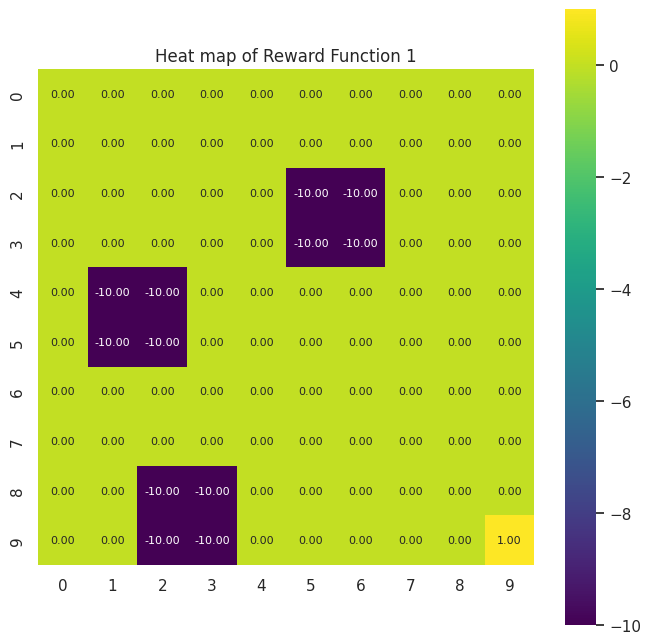

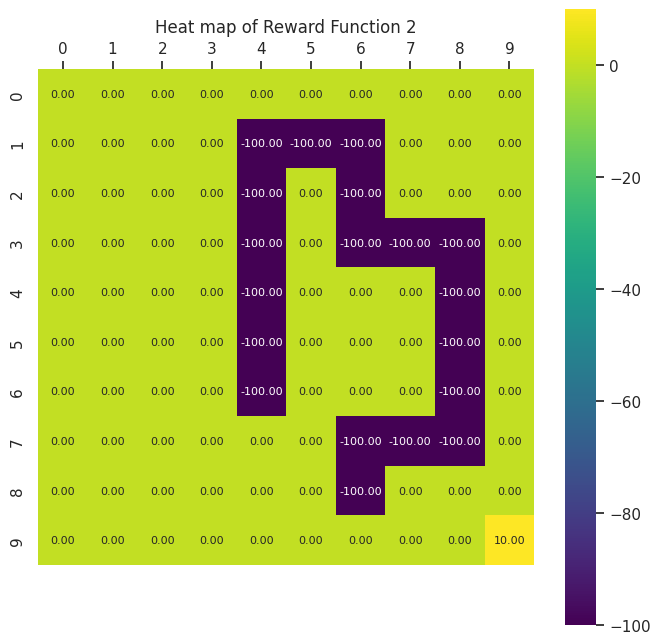

In [ ]:
# Plot Reward 1 and Reward 2
plot_heat_map(grid_pt1.reward1, "Heat map of Reward Function 1", 'Q1a.png')
plot_heat_map(grid_pt1.reward2, "Heat map of Reward Function 2", 'Q1b.png')

# Q2 and Q3 - Set up and visualize the environment for the agent

1.   Above we have already created the grid object containing:
     *   State Space
     *   Action Set
     *   Transition Probabilities
     *   Discount Factor
     *   Reward Function


2.   We initialized our grid object with the parameters specified in the project docs:
    *   Grid Size: 10X10 (e.g. **100 states**)
    *   Actions: Four - **Up, Down, Left, Right**
    *   Wind: **0.1**
    *   Discount Factor: **0.8**
    *   Reward Function: **Reward Function 1**

3.  Below we write an **Optimal State-Value Function**:
    *   **Input**: environment of the agent
    *   **Output**: optimal value of each state of the grid
    *   **Initialization:**: Implement lines 2-4
    *   **Estimation:** Implement lines 5-13 using **0.01 for epsilon**

4.  Then we **plot the optimal values** of each state in grid form

5.  We also **plot snapshots** of state values in 5 steps linarly distributed from 1-N with N being the step number of convergence. Report step numbers and N




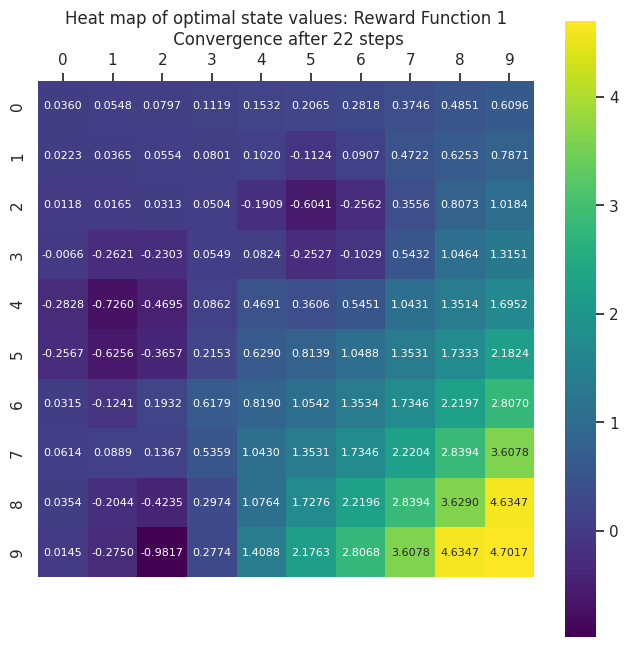

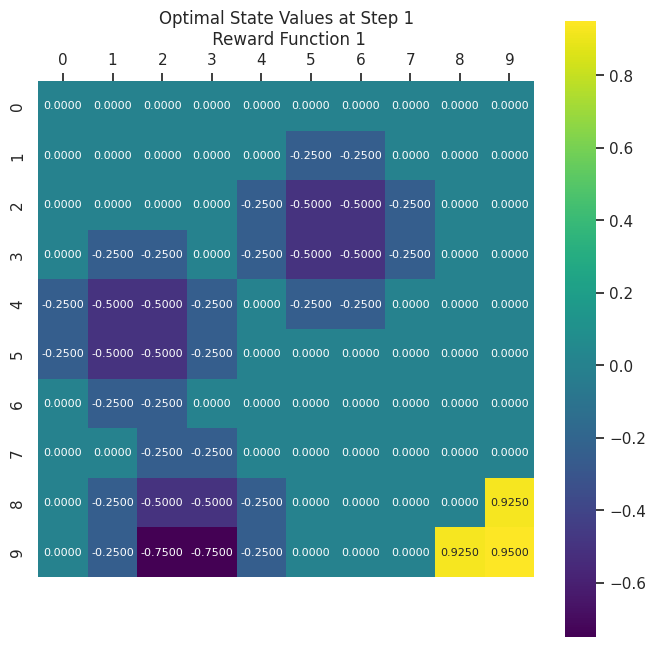

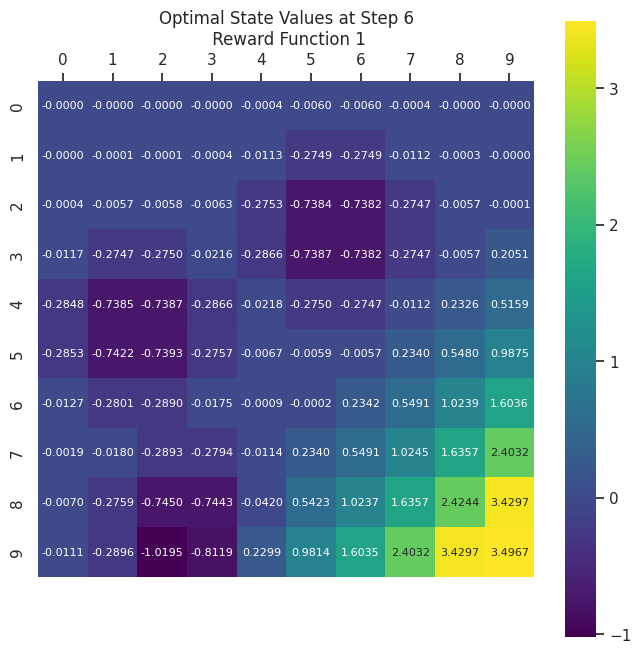

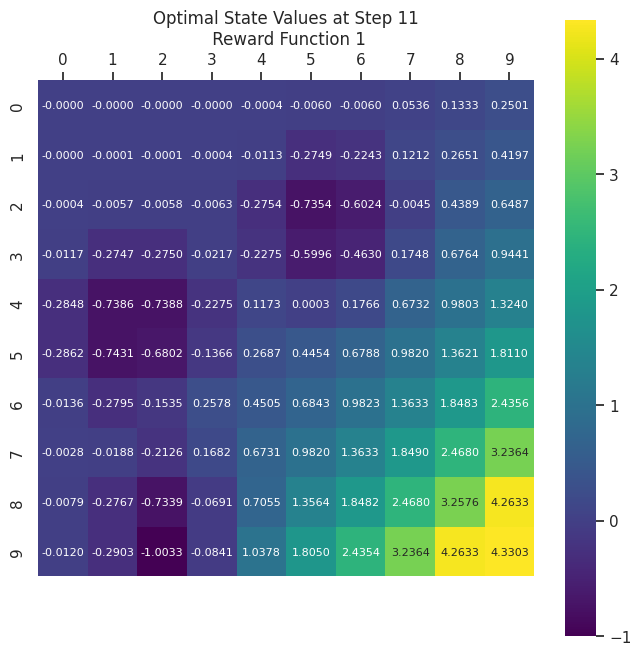

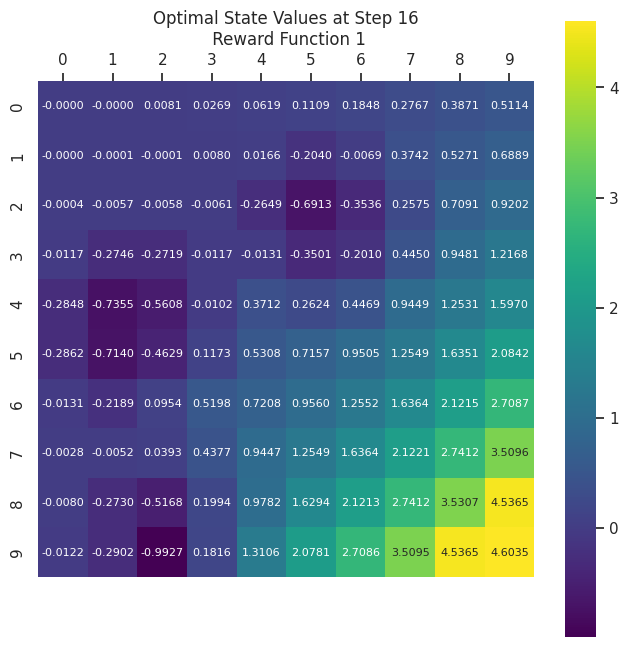

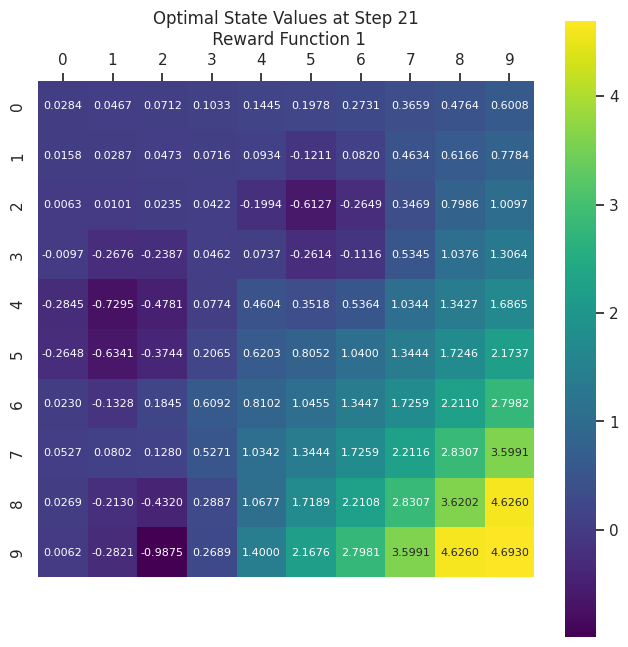

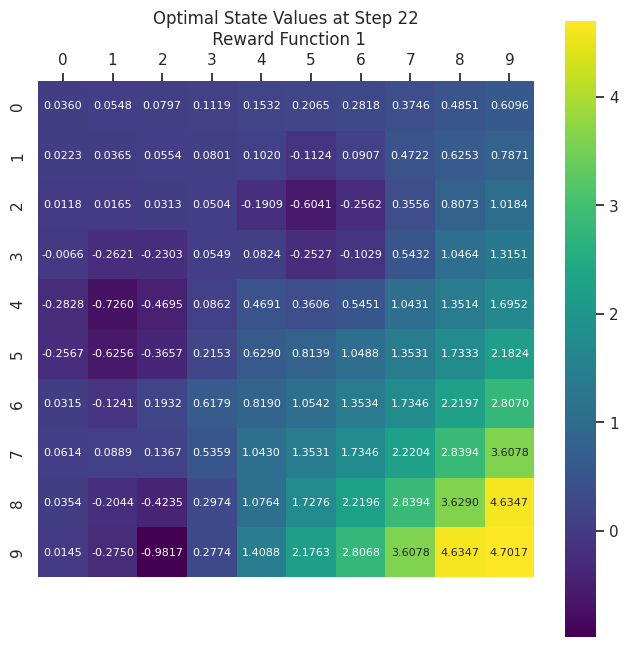

In [ ]:
# Q2 and Q3

# Compute the optimal value of each state
V, N, _ = optimal_value(grid = grid_pt1, gamma = grid_pt1.discount)

# Plot results
plot_heat_map(grid_arr = grid_to_matrix(V, grid_pt1.grid_size),
              title = f'Heat map of optimal state values: Reward Function 1\n Convergence after {N:d} steps',
              save_fn='Q2a_new.png',
              fmt = '.4f',)

# Now that we know N, capture five snapshots from 1-N
_, _, snapshots = optimal_value(grid = grid_pt1,
                                gamma = grid_pt1.discount,
                                snapshots=True,
                                snap_inc= (N-2)//4) # We want snapshots 1, N and three in between

# Plot V snapshots from 1-N
for i, snapshot in enumerate(snapshots):
  plot_heat_map(grid_arr = grid_to_matrix(snapshot[1],grid_pt1.grid_size),
                title = f'Optimal State Values at Step {snapshot[0]:d}\n Reward Function 1',
                save_fn=f'Q2b{i:d}.png',
                fmt = '.4f',)

# Q5 - Compute the optimal policy (Π) of the agent navigating the grid

1.   Implement the **computation step** (lines 14-17) of the value iteration algorithm to compute the **optimal policy (Π)**
2.   **Plot** the **optimal policy** as a grid of optimal actions for each state

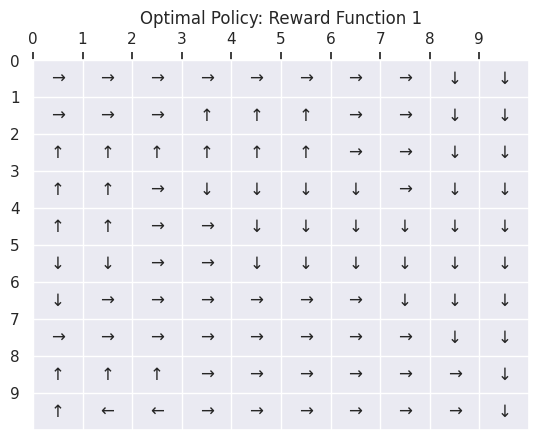

In [ ]:
# Q5 - Calculate and plot the optimal actions for each state in the grid

# Now that we know the optimal state values (V), let's find the optimal policy
policy_arr = find_policy(grid_pt1, V, gamma=grid_pt1.discount)

# Plot the optimal policy
plot_arrow(action_matrix = grid_to_matrix(policy_arr, 10),
           title = f'Optimal Policy: Reward Function 1',
           save_fn = 'Q5.png')


# Q6 - Q8: Repeat the process in Q2-Q5 but with Reward Function 2

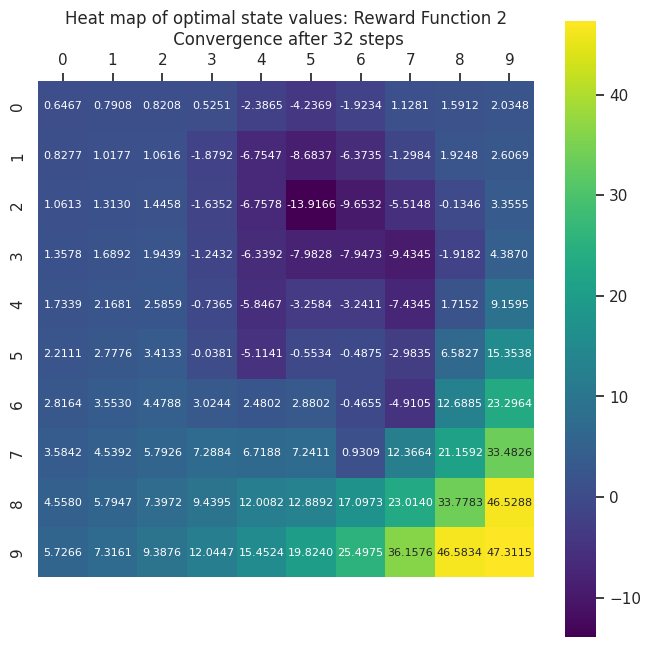

In [ ]:
# Q6 & Q7

# Let's change the grid's reward_function attribute to use Reward Function 2,
# which is already defined as an option within the grid object
grid_pt1.set_reward_function(function_type="reward 2")

# Compute the optimal value of each state
V, N, _ = optimal_value(grid = grid_pt1, gamma = grid_pt1.discount)

# Plot results
plot_heat_map(grid_arr = grid_to_matrix(V, grid_pt1.grid_size),
              title = f'Heat map of optimal state values: Reward Function 2\n Convergence after {N:d} steps',
              save_fn = "Q6_7.png",
              fmt= '.4f')

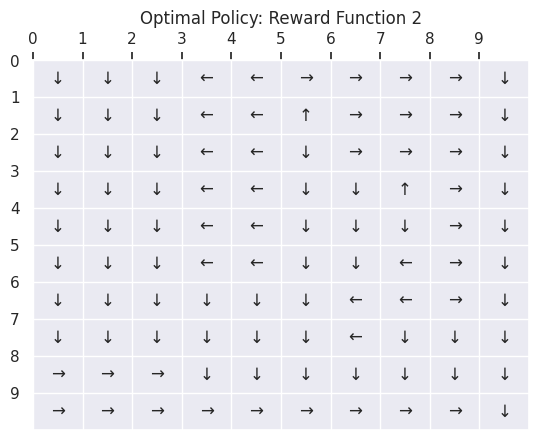

In [ ]:
# Q8 - Repeat Q5 but this time using Reward Function 2
#      Calculate and plot the optimal actions for each state in the grid

# Now that we know the optimal state values (V), let's find the optimal policy
policy_arr = find_policy(grid_pt1, V, gamma=grid_pt1.discount)

# Plot the optimal policy
plot_arrow(action_matrix = grid_to_matrix(policy_arr, 10),
           title = f'Optimal Policy: Reward Function 2',
           save_fn = 'Q8.png')

# Q9 - Experiment with a **windy grid**: analyzing effects of **adjusting hyper-parameter w**

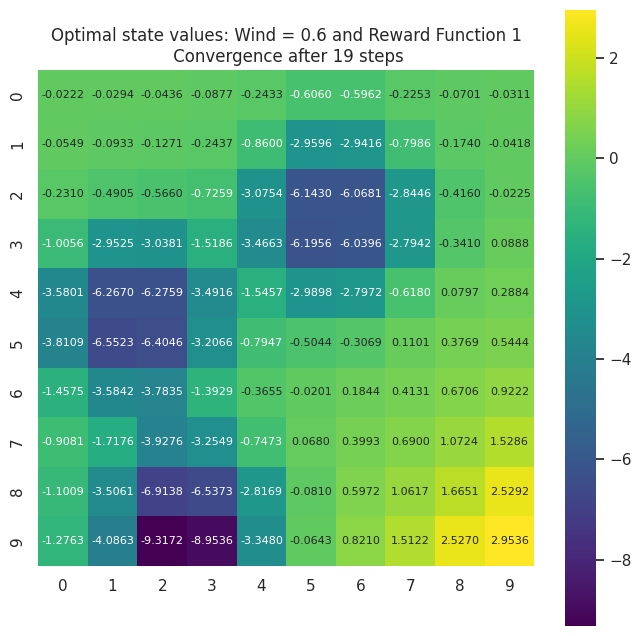

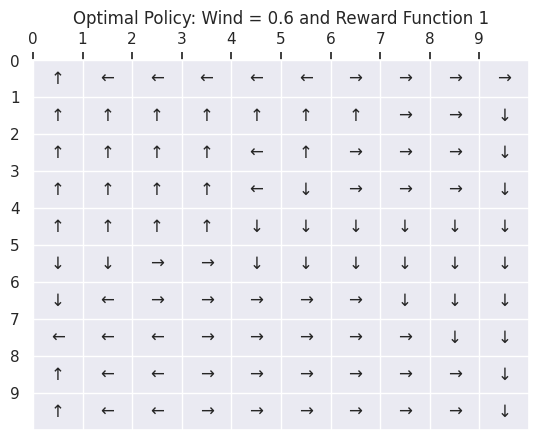

In [ ]:
# Q9 - Repeat the process of finding the optimal state values and using them to
#      compute the optimal policy using Reward Function 1 and 2, but this time use
#      0.6 as the value of the hyper-parameter w (wind). To achieve this we will
#      instantiate a new GridWorld object since initialization of the object
#.     depends on the value of the wind attribute

# Let's set up a new grid (GridWorld MDP) with the same parameters specified in
# except this time wind is set to 0.6 instead of 0.1
grid_size = 10
wind = 0.6
discount = 0.8

# Make new Windy gridworld. Reward Function initially defaults to Reward
# Function 1. We will set it to Reward Function 2 later
windy_grid = Gridworld(grid_size, wind, discount)

# Get optimal state values - Windy Grid and Reward Function 1
V, N, _ = optimal_value(grid = windy_grid, gamma = discount)

# Plot results - Windy Grid and Reward Function 1
plot_heat_map(grid_arr = grid_to_matrix(V, windy_grid.grid_size),
              title = f'Optimal state values: Wind = 0.6 and Reward Function 1\n Convergence after {N:d} steps',
              save_fn = 'Q9a.png',
              fmt='.4f')

# Now that we know the optimal state values (V), let's find the optimal policy
# for Windy grid with Reward Function 1
policy_arr = find_policy(windy_grid, V, gamma=discount)

# Plot the optimal policy - Windy Grid with Reward Function 1
plot_arrow(action_matrix = grid_to_matrix(policy_arr, 10),
           title = f'Optimal Policy: Wind = 0.6 and Reward Function 1',
           save_fn = 'Q9b.png')

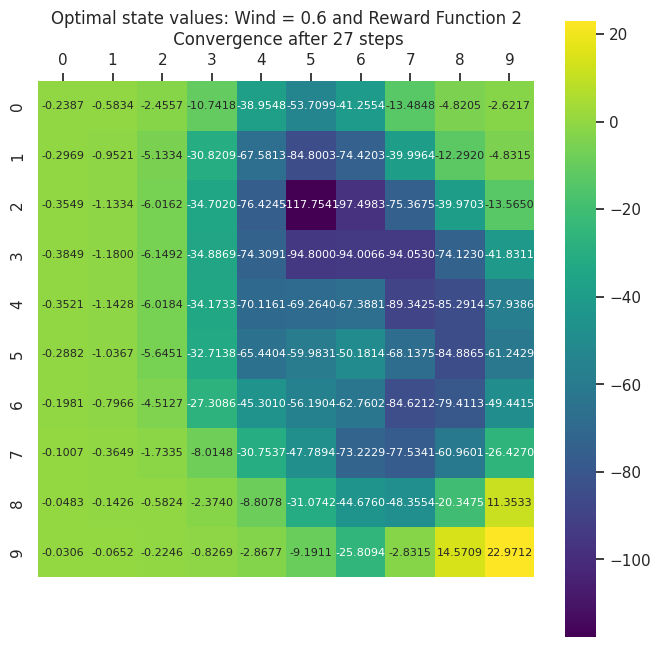

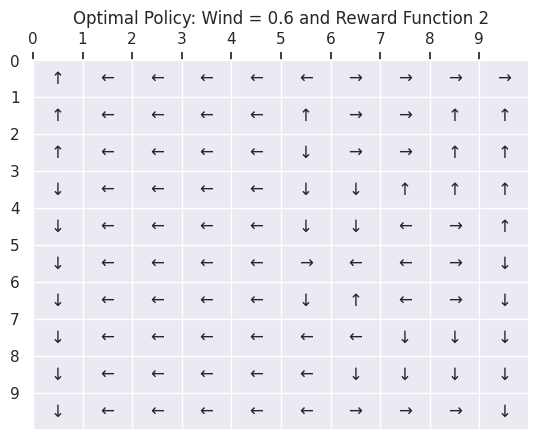

In [ ]:
# Q9 Continued

# Set reward function to Reward Function 2
windy_grid.set_reward_function(function_type = "reward 2")

# Get optimal state values - Windy Grid and Reward Function 2
V, N, _ = optimal_value(grid = windy_grid, gamma = windy_grid.discount)

# Plot results - Windy Grid and Reward Function 2
plot_heat_map(grid_arr = grid_to_matrix(V, windy_grid.grid_size),
              title = f'Optimal state values: Wind = 0.6 and Reward Function 2\n Convergence after {N:d} steps',
              save_fn = 'Q9c.png',
              fmt='.4f')

# Now that we know the optimal state values (V), let's find the optimal policy
# for Windy grid with Reward Function 2
policy_arr = find_policy(windy_grid, V, gamma=windy_grid.discount)

# Plot the optimal policy - Windy Grid with Reward Function 2
plot_arrow(action_matrix = grid_to_matrix(policy_arr, 10),
           title = f'Optimal Policy: Wind = 0.6 and Reward Function 2',
           save_fn = 'Q9d.png')

In [ ]:
print(windy_grid.reward_function)

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 -10 -10   0   0   0]
 [  0   0   0   0   0 -10 -10   0   0   0]
 [  0 -10 -10   0   0   0   0   0   0   0]
 [  0 -10 -10   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0 -10 -10   0   0   0   0   0   0]
 [  0   0 -10 -10   0   0   0   0   0   1]]


# Part 2: Inverse Reinforcement Learning

# Helper functions to support Part 2

In [ ]:
# Determine the similarity between two policies. Returns a number between
# 0 and 1 with 1 representing perfect accuracy
def accuracy(policy1, policy2):

  if len(policy1) != len(policy2):
    return 0

  else:
    num_states = len(policy1)
    num_correct = 0

    for i in range(num_states):
      if policy1[i] == policy2[i]:
        num_correct += 1

    return num_correct/num_states

In [ ]:
# Helper function to construct the linear programing matrices: c, D, b
def build_lp_matrices(policy, P, gamma, lmda, Rmax):

  D=np.array([])
  num_actions=4
  num_states=100

  I = np.identity(100)   # Set up an identity matrix (sxs to match state space)
  Z = np.zeros((100, 100)) # Set up zero matrix same shape as state space

  Pa1=np.zeros((100,100))
  Pas=np.zeros((3,100,100))

  # Loop through states pulling out Pa1 for each one and building Pas with the
  # state-probs for the other three actions
  for s in range(num_states):
    opt_a=policy[s]
    Pa1[s,:]=P[s][opt_a]
    other_actions=np.setdiff1d(range(num_actions), opt_a)
    for i,a in enumerate(other_actions):
      Pas[i,s,:]=P[s][a]

  # Build D
  for i in range(num_actions-1):

    Pa=Pas[i]
    temp = np.hstack((I, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - 0.8*np.array(Pa1)))))
    temp = np.vstack((temp, np.hstack((Z, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - 0.8*np.array(Pa1)))))))

    if (D.shape[0]==0):
      D=temp
    else:
      D=np.vstack((temp, D))

  D=np.vstack((D, np.hstack((Z, -I, I))))
  D=np.vstack((D, np.hstack((Z, -I, -I))))
  D=np.vstack((D, np.hstack((Z, Z, I))))
  D=np.vstack((D, np.hstack((Z, Z, -I))))

  # Build b and c
  b=np.concatenate([np.zeros((800,)), Rmax*np.ones((200,))])
  c=np.concatenate([np.ones((100,)), -lmda*np.ones((100,)), np.zeros((100,))])

  return c.squeeze(),D,b.squeeze()

In [ ]:
# Helper function to (1) extract the reward function from a provided expert policy,
# (2) use the reward function to compute the optimal agent state-values (3) use
# the optimal agent state-values to compute the optimal agent policy. Function
# returns the optimal agent state-values and policy
def execute_irl(eo_policy, lmda, grid, Rmax, plot_rf=False, rf_desc='', img_fn='', epsilon = 1e-2):

  # Get c, D, and b matrices
  c,D,b = build_lp_matrices(policy = eo_policy,
                            P = grid.tr_probs,
                            gamma = grid.discount,
                            lmda=lmda,
                            Rmax = Rmax)

  # Extract reward function from expert policy

  # Initialize LP solver
  solvers.options['show_progress']=False

  # Call the solver. Note that we seek to maximize x, but solvers minimize. So,
  # we want to pass in -c. Let's check c to see Get c, D, b has performed c*(-1)
  # before returning c.
  solution = solvers.lp(-matrix(c.transpose()),matrix(D),matrix(b))

  # This line pulls out the first 100 values. So, if we want this line to extract
  # R, we need to arrange c and D so that R is the top element of the x matrix
  # R_extracted = np.array(sol['x'][:100]) # assumes R is top element of x
  R_extracted = np.array(solution['x'][-100:]).squeeze() # assumes R is last element of x

  if plot_rf:
    plot_heat_map(grid_arr = grid_to_matrix(R_extracted, grid.grid_size),
                  title = f'Heat map of Extracted Reward Function \n from Expert Policy: {rf_desc:s}',
                  save_fn = img_fn,
                  fmt= '.4f')

  # Generate agent's policy from extracted reward function
  # Set the reward_function of grid_pt2 to the extracted reward function
  # Generate V and then get the policy
  grid.set_reward_function("custom", grid_to_matrix(R_extracted, grid.grid_size))
  ao_V, N, _ = optimal_value(grid = grid, gamma = grid.discount, epsilon = epsilon)
  ao_policy = find_policy(grid, ao_V, gamma = grid.discount)

  return ao_V, ao_policy, N


# Helper function to tune hyper-parameter lambda. Function sweeps lambda from 0
# to 5 (500 evenly spaced values). For each lambda, we execute irl to obtain the
# optimal agent state-values and policy from the expert policy, Then we compare
# the agent policy to the expert policy. The function returns the lambda value
# that resulted in the best comparison accuracy.
def tune_irl_lambda(eo_policy, grid, Rmax, report_metrics=False, rf_desc='', img_fn='', epsilon = 1e-2):

  # Set up lambda vals
  lambda_vals = np.arange(0,5.01,0.01)

  # This will hold the accuracy values for each lambda
  accuracy_scores = []

  # sweep labmda values
  for i, lambda_val in enumerate(tqdm(lambda_vals)):

    #Extract reward function
    ao_V, ao_policy, _ = execute_irl(eo_policy = eo_policy,
                                     lmda = lambda_val,
                                     grid = grid,
                                     Rmax = Rmax,
                                     epsilon = epsilon)

    # compare ao_policy to eo_policy - calculate accuracy and store in list for
    # current lambda value
    accuracy_scores.append(accuracy(eo_policy, ao_policy))

  if report_metrics:

    max_accuracy = np.max(accuracy_scores)
    lambda_max = lambda_vals[np.argmax(accuracy_scores)]

    # Plot the accuracy vs. lambda value

    # Move x-axis to bottom
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True

    plt.plot(lambda_vals, accuracy_scores)

    plt.plot(lambda_max,
             max_accuracy,
             label=f'best accuracy: {max_accuracy:.2f}',
             marker = "*",
             markersize = 10,
             color = 'r')

    plt.axvline(lambda_max,
                color='r',
                linestyle='--',
                label=f'achieved with lambda: {lambda_max:.2f}')

    plt.xlabel('Lambda')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy of Optimal Policy Learned through IRL\n vs. Lambda Value: {rf_desc:s}')
    plt.legend(fontsize='small')
    if img_fn != '':
      plt.savefig(image_path+img_fn,dpi=300,bbox_inches='tight')

    plt.show()

  return lambda_vals[np.argmax(accuracy_scores)]

# Q11-Q17 - Using Reward Function #1

In [ ]:
# For Q11 we are told to use the expert policy from Q5 in part 1. We are also
# told that we may play around with optimizing. Let's start with the standard
# version. Once we get this working we can go back and optimize

# Let's recreate the expert policy. We will name intermediate data objects
# eo_xxx for expert-optimal

# Set up the grid. Let's call it grid_pt2 to distinguish it from other grids
grid_pt2 = Gridworld(grid_size = 10, wind = 0.1, discount = 0.8)

# Compute the optimal value of each state
eo_V, _, _ = optimal_value(grid = grid_pt2, gamma = grid_pt2.discount)

# Now that we know the optimal state values (V), let's find the optimal policy
eo_policy = find_policy(grid_pt2, eo_V, gamma=grid_pt2.discount)

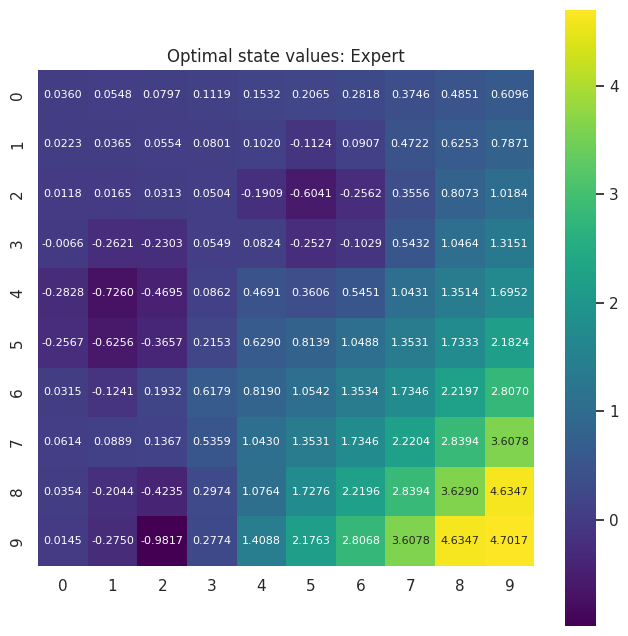

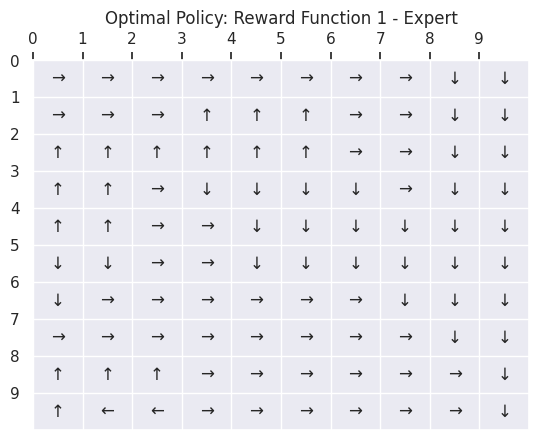

In [ ]:
# Let's check our state values and expert policy
plot_heat_map(grid_arr = grid_to_matrix(eo_V, grid_pt2.grid_size),
              title = 'Optimal state values: Expert',
              fmt = '.4f')

# Plot the optimal policy
plot_arrow(action_matrix = grid_to_matrix(eo_policy, 10),
           title = 'Optimal Policy: Reward Function 1 - Expert')

100%|██████████| 501/501 [03:16<00:00,  2.56it/s]


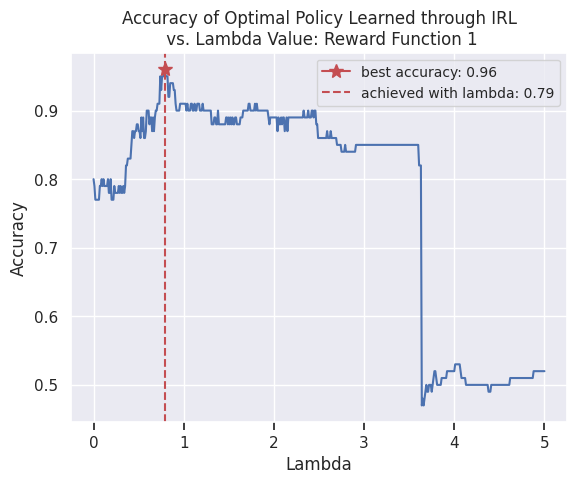

In [ ]:
# Q11 & 12 - Compute and report lambda1_max
lambda1_max = tune_irl_lambda(eo_policy = eo_policy,
                              grid = grid_pt2,
                              Rmax = 10,
                              report_metrics = True,
                              rf_desc='Reward Function 1',
                              img_fn = 'Q11.png')

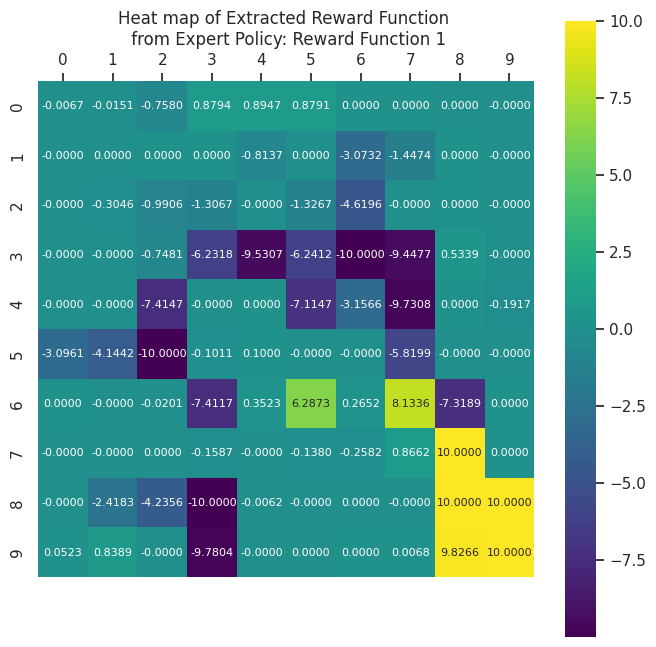

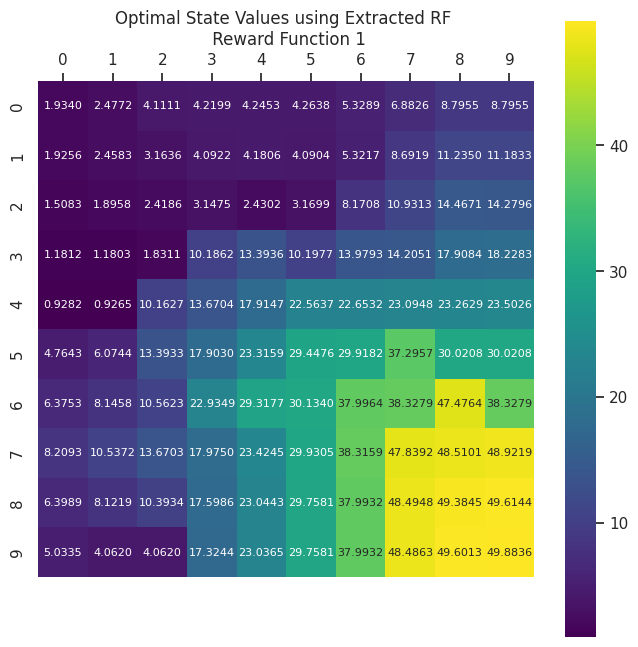

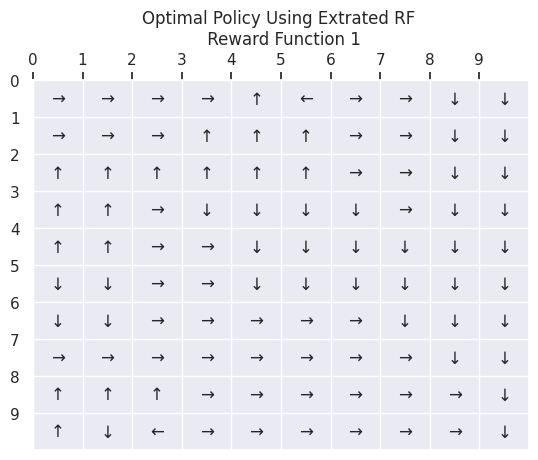

In [ ]:
# Q13-Q16

# Q13 - Compute the IRL extracted reward function with lambda = lambda1_max and
# plot the extracted reward function.
ao_V, ao_policy, _ = execute_irl(eo_policy = eo_policy,
                                lmda = lambda1_max,
                                grid = grid_pt2,
                                Rmax = 10,
                                plot_rf = True,
                                rf_desc = 'Reward Function 1',
                                img_fn = 'Q13.png')

# Q14 - Plot optimal state value matrix
plot_heat_map(grid_arr = grid_to_matrix(ao_V, grid_pt2.grid_size),
              title = f'Optimal State Values using Extracted RF \n Reward Function 1',
              save_fn = 'Q14.png',
              fmt = '.4f')

# Q16 - Plot the optimal policy
plot_arrow(action_matrix = grid_to_matrix(ao_policy, grid_pt2.grid_size),
           title = 'Optimal Policy Using Extrated RF \n Reward Function 1',
           save_fn = 'Q16.png')

# Q18-Q24 - Using Reward Function 2

In [ ]:
# Now we repeat the process from Q11-Q17 but with Reward Function 2

# We will reuse grid_pt2, but we need to set the reward function to Reward 2
grid_pt2.set_reward_function('reward 2')

# Compute the optimal value of each state
eo_V, _, _ = optimal_value(grid = grid_pt2, gamma = grid_pt2.discount)

# Now that we know the optimal state values (V), let's find the optimal policy
eo_policy = find_policy(grid_pt2, eo_V, gamma=grid_pt2.discount)

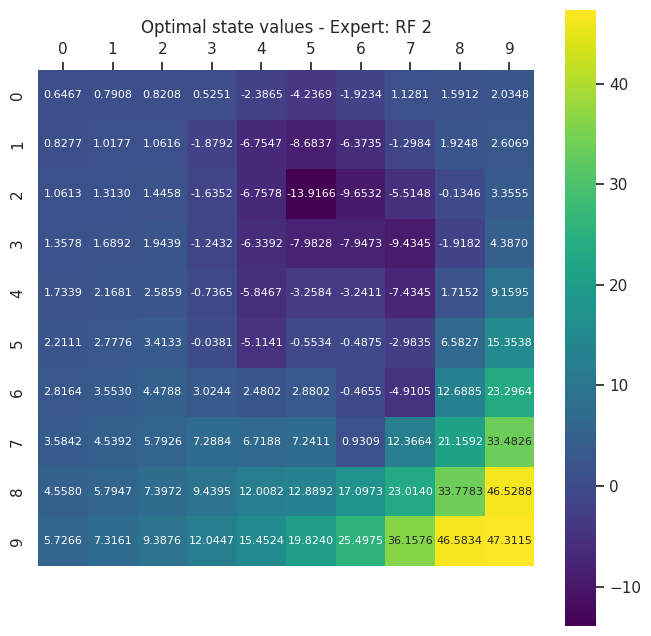

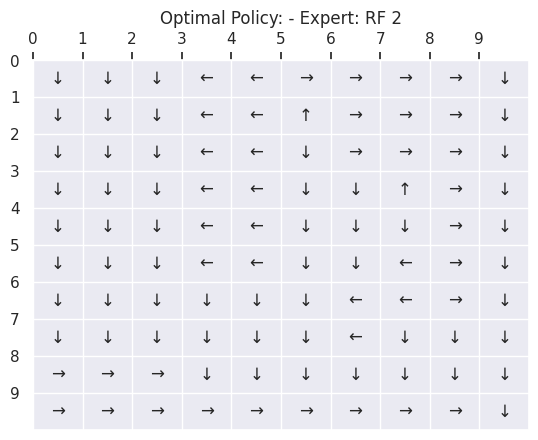

In [ ]:
# Let's check our state values and expert policy
plot_heat_map(grid_arr = grid_to_matrix(eo_V, grid_pt2.grid_size),
              title = 'Optimal state values - Expert: RF 2',
              fmt = '.4f')

# Plot the optimal policy
plot_arrow(action_matrix = grid_to_matrix(eo_policy, 10),
           title = 'Optimal Policy: - Expert: RF 2')

100%|██████████| 501/501 [03:09<00:00,  2.64it/s]


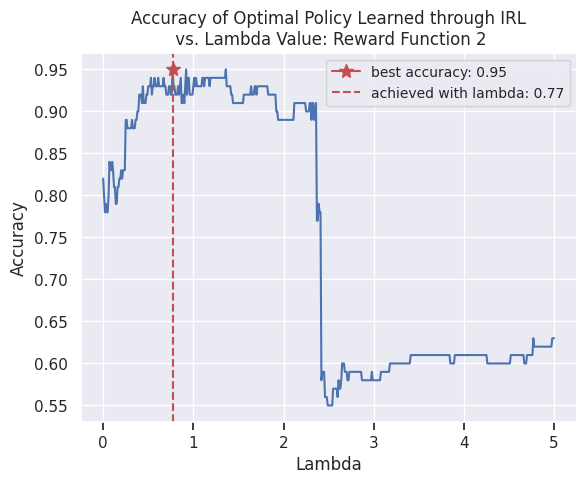

In [ ]:
# Q18 & 19 - Compute and report lambda1_max
lambda2_max = tune_irl_lambda(eo_policy = eo_policy,
                              grid = grid_pt2,
                              Rmax = 100,
                              report_metrics = True,
                              rf_desc='Reward Function 2',
                              img_fn = 'Q18.png')

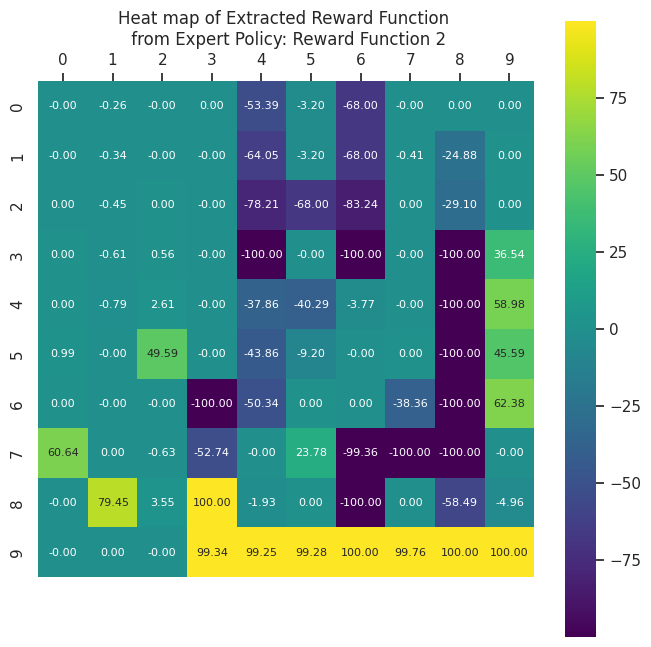

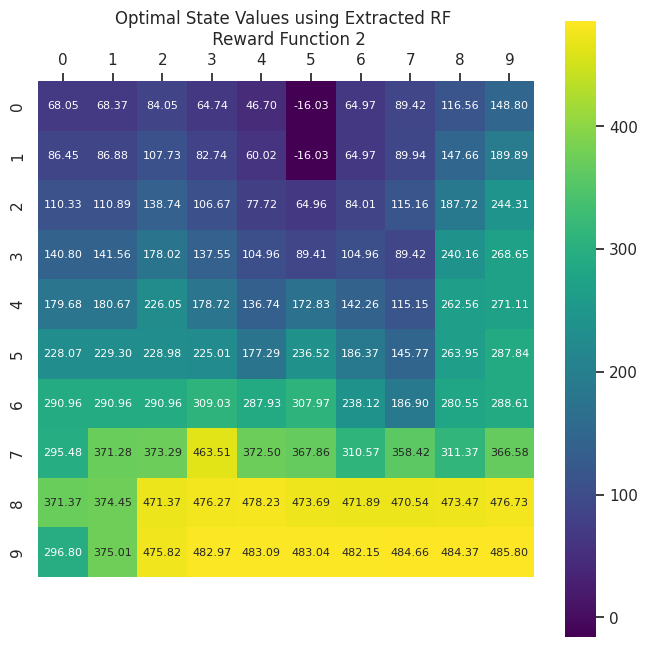

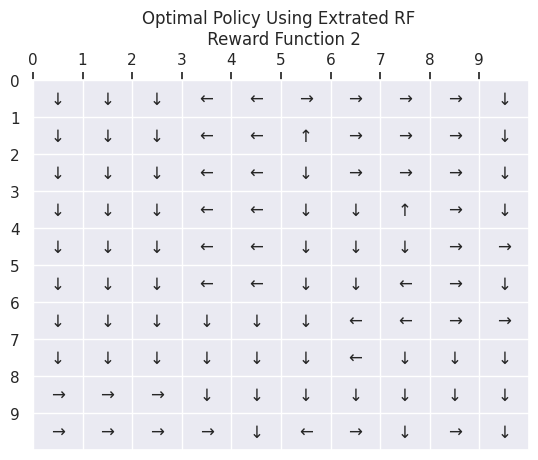

In [ ]:
# Q20-Q23

# Q20 - Compute the IRL extracted reward function with lambda = lambda1_max and
# plot the extracted reward function.
ao_V, ao_policy, N = execute_irl(eo_policy = eo_policy,
                                 lmda = lambda2_max,
                                 grid = grid_pt2,
                                 Rmax = 100,
                                 plot_rf = True,
                                 rf_desc = 'Reward Function 2',
                                 img_fn = 'Q20.png')

# Q21 - Plot optimal state value matrix
plot_heat_map(grid_arr = grid_to_matrix(ao_V, grid_pt2.grid_size),
              title = f'Optimal State Values using Extracted RF \n Reward Function 2',
              save_fn = 'Q21.png',
              fmt = '.2f')

# Q23 - Plot the optimal policy
plot_arrow(action_matrix = grid_to_matrix(ao_policy, grid_pt2.grid_size),
           title = 'Optimal Policy Using Extrated RF \n Reward Function 2',
           save_fn = 'Q23.png')

# Q25 - Investigate and correct the first discrepancy in the IRL produced optimal policy

In [ ]:
def run_irl_exp (grid, rmax, lambda_val, desc, save_fns=[], epsilon=0.01, plot_sv=True, plot_pol=True):

  save_fn = ''
  # Execute IRL:
  eo_policy = find_policy(grid=grid, gamma=grid.discount)

  ao_V, ao_policy, N = execute_irl(eo_policy = eo_policy,
                                   lmda = lambda_val,
                                   grid = grid,
                                   Rmax = rmax,
                                   epsilon=epsilon)

  # Plot agent's state-values and policy along with the number of steps to converge
  if plot_sv:
    if len(save_fns) != 0: save_fn = save_fns.pop()
    plot_heat_map(grid_arr = grid_to_matrix(ao_V, grid.grid_size),
                  title = f'Optimal SVs - IRL Extracted RF:{desc:s} \n epsilon = {epsilon:f} - Convergence after {N:d} steps',
                  save_fn = save_fn,
                  annot=True)

  if plot_pol:
    if len(save_fns) != 0: save_fn = save_fns.pop()
    acc = accuracy(eo_policy, ao_policy)
    plot_arrow(action_matrix = grid_to_matrix(ao_policy, grid.grid_size),
               title = f'Opt Policy - IRL Extracted RF:{desc:s}  \n epsilon = {epsilon:f}   Accuracy = {acc:.2f}',
               save_fn = save_fn)

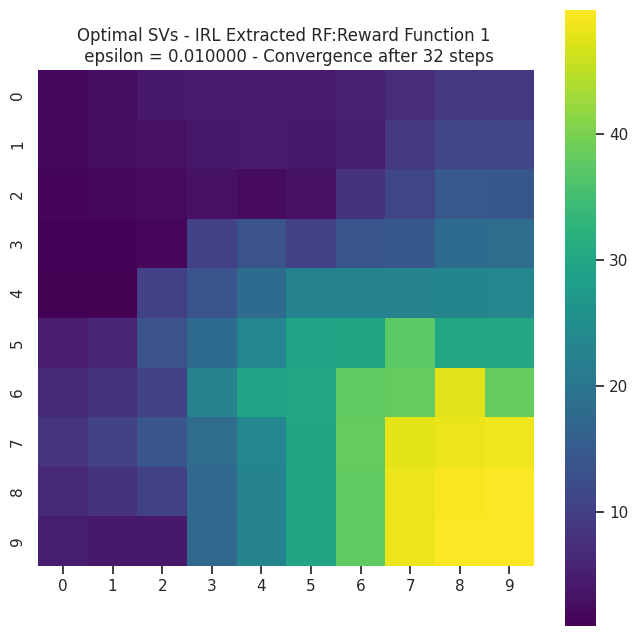

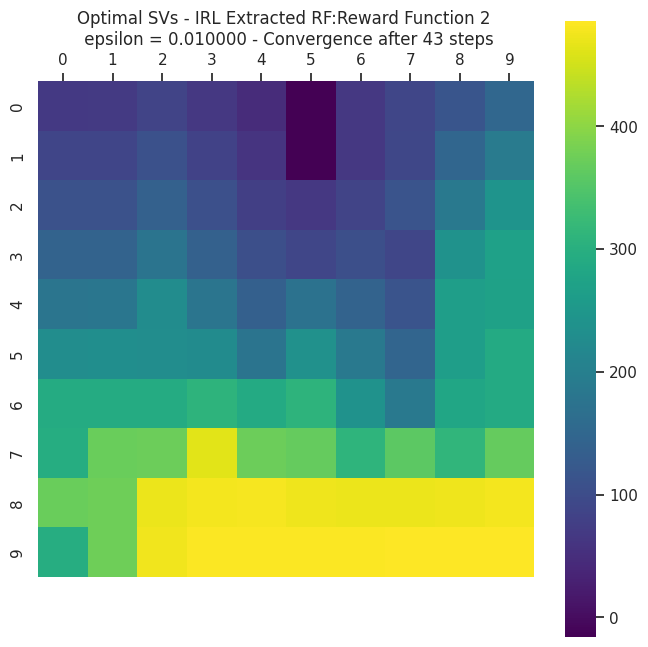

In [ ]:
# Q25 - Fix the first discrepancy in the IRL produced policy by modifying the
# Value Iteration Function: optimal_value()
lambda1_max = 0.79
lambda2_max = 0.77

# The first discrepancy is that the optimal policy instructs the agent to move
# off of the grid at points. The intuition is that we could achieve better
# accuracy with a lower epsilon - which is current set to 0.01. Let's first
# investigate the number of steps it takes for our optimal values algorithm to
# converge.

# Set up a fresh grid.
grid_q25 = Gridworld(grid_size = 10, wind = 0.1, discount = 0.8)

# Execute IRL: Reward Function 1
run_irl_exp (grid=grid_q25,
             rmax=10,
             lambda_val=lambda1_max,
             desc='Reward Function 1',
             save_fns=['Q25a.png'],
             plot_pol=False)

# Execute IRL: Reward Function 2
grid_q25.set_reward_function("reward 2")
run_irl_exp (grid=grid_q25,
             rmax=100,
             lambda_val=lambda2_max,
             desc='Reward Function 2',
             save_fns=['Q25b.png'],
             plot_pol=False)

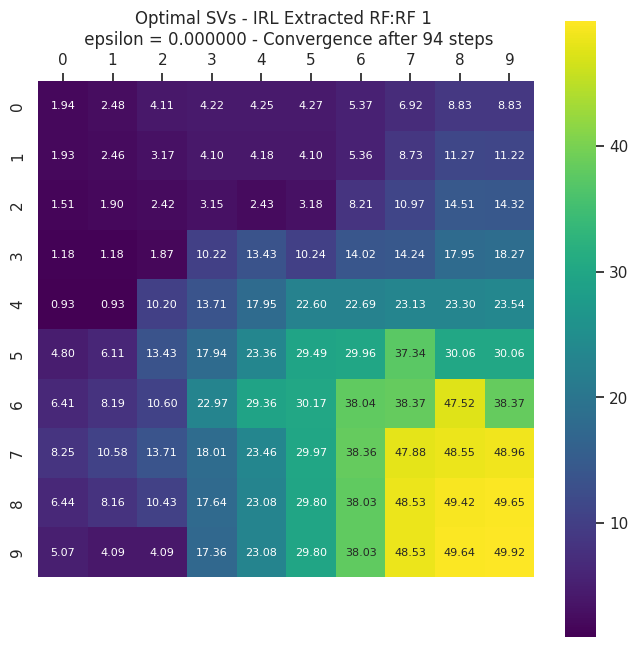

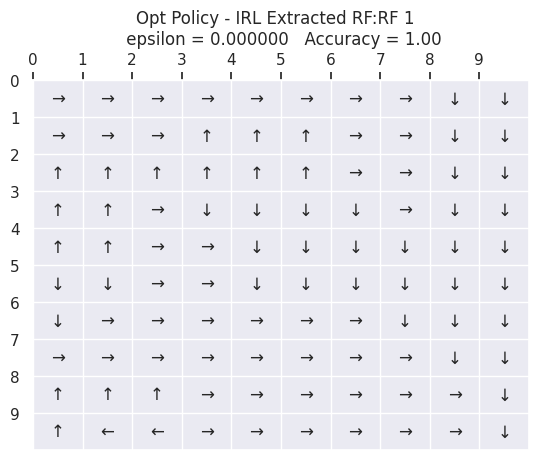

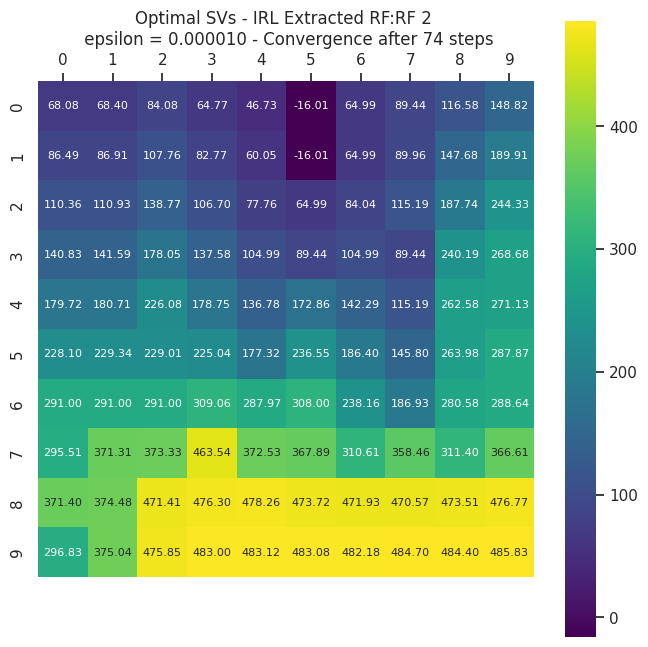

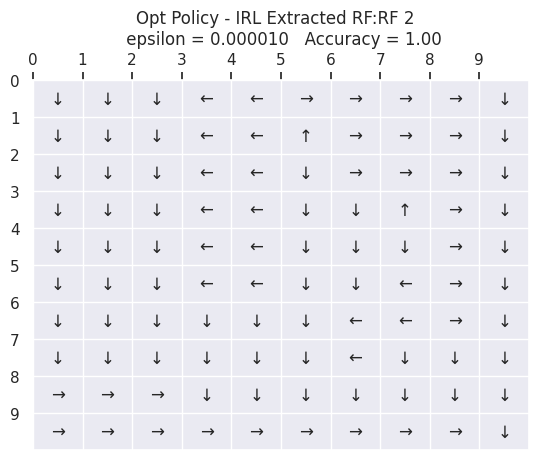

In [ ]:
# The first thing we are going to try is to simply adjust epsilon. Right now the
# function accepts epsilon as an optional parameter which defautls to 0.01

# Set up a fresh grid.
grid_q25 = Gridworld(grid_size = 10, wind = 0.1, discount = 0.8)

# Execute IRL with adjusted epsilon:Rmax of Extracted RF/1000 Reward Function 1
run_irl_exp (grid=grid_q25,
             rmax=10,
             lambda_val=lambda1_max,
             desc='RF 1',
             save_fns=['Q25c.png', 'Q25d.png'],
             epsilon=1e-08)

# Execute IRL: Reward Function 2
grid_q25.set_reward_function("reward 2")
run_irl_exp (grid=grid_q25,
             rmax=100,
             lambda_val=lambda2_max,
             desc='RF 2',
             save_fns=['Q25e.png', 'Q25f.png'],
             epsilon=1e-05)

100%|██████████| 501/501 [04:56<00:00,  1.69it/s]


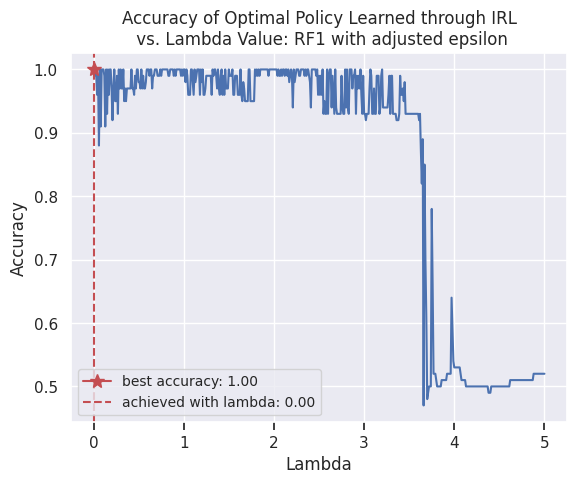

In [ ]:
# Finally, let's re-tune the hyperparameter lambda using the adjusted epsilon
# and see if we get a better lamda_max.

# Refresh the grid and get expert policy
grid_q25 = Gridworld(grid_size = 10, wind = 0.1, discount = 0.8)
eo_policy = find_policy(grid=grid_q25, gamma=grid_q25.discount)

#Compute and report lambda1_max
lambda1_max = tune_irl_lambda(eo_policy = eo_policy,
                              grid = grid_q25,
                              Rmax = 10,
                              report_metrics = True,
                              rf_desc='RF1 with adjusted epsilon',
                              img_fn = 'Q25g.png',
                              epsilon = 1e-8)

100%|██████████| 501/501 [03:55<00:00,  2.13it/s]


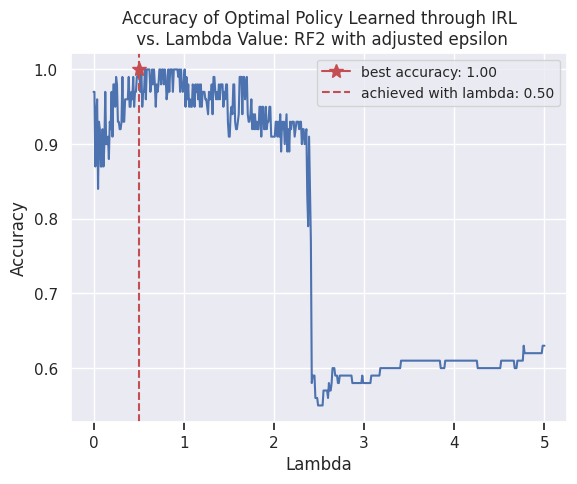

In [ ]:
# Set reward function back to reward 2
grid_q25.set_reward_function('reward 2')
eo_policy = find_policy(grid=grid_q25, gamma=grid_q25.discount)

#Compute and report lambda1_max
lambda2_max = tune_irl_lambda(eo_policy = eo_policy,
                              grid = grid_q25,
                              Rmax = 100,
                              report_metrics = True,
                              rf_desc='RF2 with adjusted epsilon',
                              img_fn = 'Q25h.png',
                              epsilon = 1e-5)

<ipython-input-4-581da4a54086>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grid_matrix[int(i%dim)][int(i/dim)] = grid_arr[i]


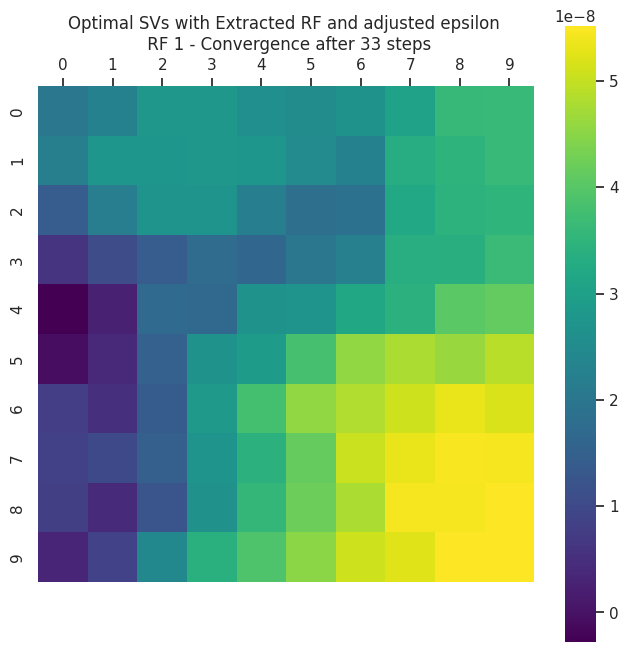

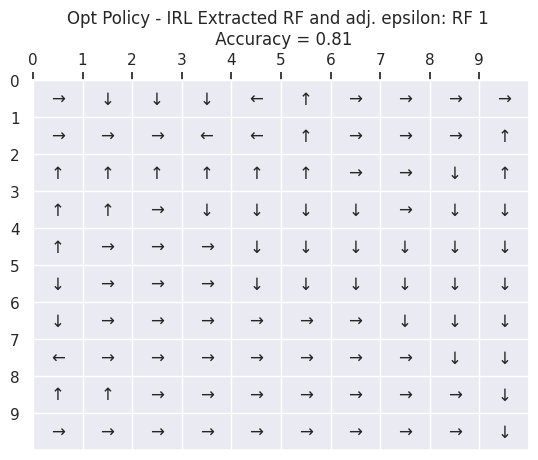

<ipython-input-4-581da4a54086>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grid_matrix[int(i%dim)][int(i/dim)] = grid_arr[i]


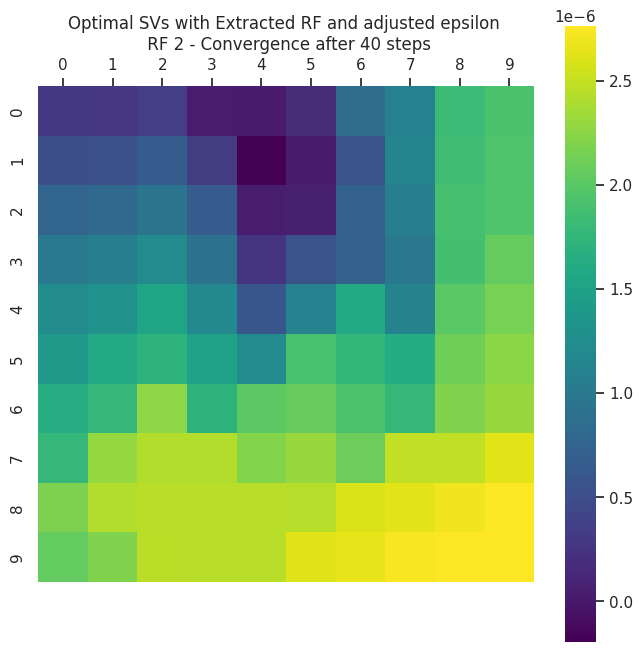

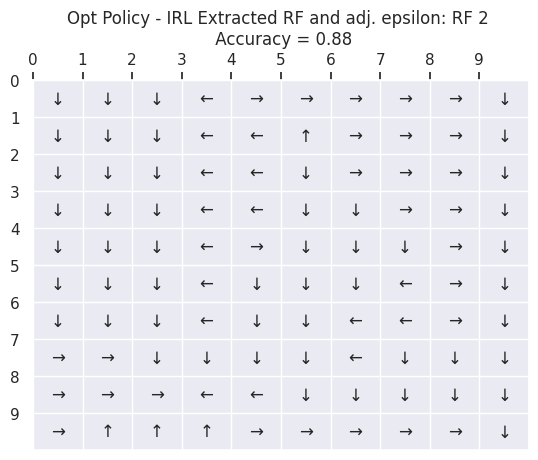

In [ ]:
# Tuning lambda with the adjusted epsilon yeailded the same result for Reward
# Function 1. So, We will just re-run IRL for Reward Function 2 with the
# new lambda and adjusted epsilon.

# Set up a fresh grid.
grid_q25 = Gridworld(grid_size = 10, wind = 0.1, discount = 0.8)

# Execute IRL: Reward Function 1
run_irl_exp (grid=grid_q25,
             rmax=1,
             lambda_val=lambda1_max,
             desc='RF 1',
             save_fns=['Q25e.png', 'Q25f.png'],
             epsilon=1e-11)

# Execute IRL: Reward Function 2
grid_q25.set_reward_function("reward 2")
run_irl_exp (grid=grid_q25,
             rmax=10,
             lambda_val=lambda2_max,
             desc='RF 2',
             save_fns=['Q25e.png', 'Q25f.png'],
             epsilon=1e-10)